# OM x PSG - T-shirt Recognition

**Convolutional Neural Networks in Python**

This notebook intends to build a Convolutional Neural Networks to image recognition.

**Problem Description**

Image recognition is nowadays a huge technique with many applications to vary problems. Here, we build a Convolutional Neural Network (CNN) capable to predict two class of image, cat and dog. We consider in this notebook a CNN that will be built for us and a CNN from a pre-trained network. The objective is to compare both models and select the best, considering some parameters as accuracy and loss function.

**Dataset Description**

The dataset is composed by 16000 images and two class, cat and dog. We consider two folders, one to training set with 8000 images and one to the test set with 8000 images. To make predictions, we consider some images that were not trained and tested before.

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf # To build the CNN

tf.__version__

from tensorflow import keras # Calling keras
from tensorflow.keras import layers # to create the layers of neurons
from tensorflow.keras.models import Sequential # to create the Neural Network
from keras.preprocessing.image import ImageDataGenerator # Image processing

# Data Preprocessing

## Loading the training and test set

Defining some parameters to load the dataset. Batch size is defined to the CNN, it's the number of image considered to each retro-propagation process when we consider the SGD. Image height and width are the image configuration, it means, the size that we want to consider for each image.

In [2]:
batch_size = 32
img_height = 180
img_width = 180

### Training set

Loading the training set from a specific path using Keras image prepocessing.

In [3]:
train_set = keras.preprocessing.image_dataset_from_directory(
  'Dataset/Training',
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1600 files belonging to 2 classes.


### Test set

Loading the test set from a specific path using Keras image prepocessing.

In [4]:
test_set = keras.preprocessing.image_dataset_from_directory(
  'Dataset/Validation',
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 800 files belonging to 2 classes.


### Class names

To verify the class in the problem.

In [5]:
class_names = train_set.class_names
print(class_names)

['OM', 'PSG']


### Visualizing the data

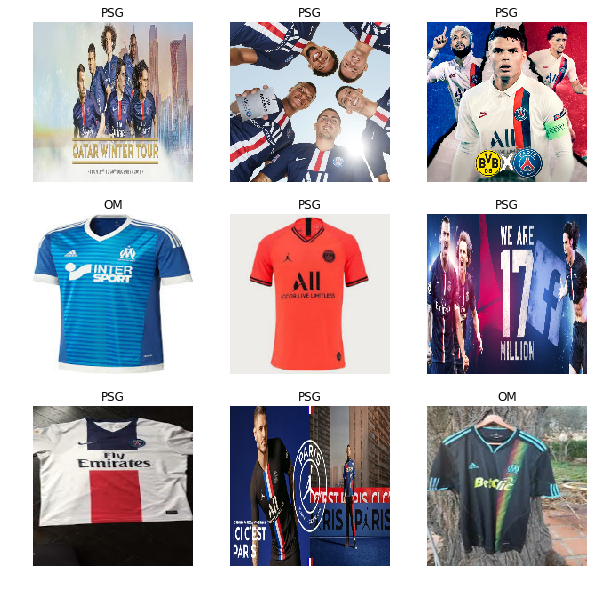

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## Configure the dataset for performance

Here, we configure the dataset for a better computational performance, to know more details, [see](https://www.tensorflow.org/guide/data_performance).

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

## Standardization of the data

The standardization of the data is a very important step to build a CNN, due to consider a classification model, we must to have the data points in the same scale. When we consider an image, the pixels values varying between 0 and 255. We want to have values between 0 and 1,  to do it, we consider the image standardization.

In [8]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)) # object to rescale

In [9]:
normal_train_set = train_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normal_train_set))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

normal_test_set = test_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normal_test_set))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

# Here we have scaled both set, but this is a simple demonstration. We are going to employ it directly from the model implemetation, as we can see below.

0.0 1.0
0.0 1.0


# Building the CNN model by hand

The Convolutional Neural Network is a technique to image recognition. The name Convolution is attributed due to the convolution method employed to the images. Summary, this method method takes care about the image, transforming it into a numerical matrix. As we know, an image can be represented by pixels. The range of pixels varies between 0 and 255 (black to white). So, once time that we have an image represented by numbers, in specific a matrix, to built a CNN, we must to follow some steps to obtain an one dimensional array capable to be trained. The steps which compose a CNN are Convolution, Max Pooling, Flatten and Full Connection.


**Convolution** is a method to transform the original matrix (which contains the pixels from one image), we consider in this step many filters (like in signal treatment, we employ a filter to obtain a signal more clean). For example, if we consider an image as a matrix 32x32 we can apply a filter (matrix 2x2). Each filter that we employ has a function, as eliminate some colors or eliminate shadow. In this step we consider a range of filters, to have the image transformed in many ways. This help the model to “visualize” the image in many “angles”.

**Max Pooling**  is a process where we reduce the matrix from the last step. For example, after the convolution process,  we have a transformed image, represented by a matrix (16x16), we employ a filter (matrix 2x2), but this filter considers the highest values from the matrix transformed by the convolution step. In this manner, we have a reduced matrix.

**Flatten** is a process that we transform the squared matrix into one dimensional arrray.

**Full connection** is the last step to build a CNN model. In this stage we connect the flatten vector to the input layer to make the classification. 

To visualize these process in a pedagogical approach, [see](https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html).

To this notebook, we consider four models of CNN. The first model there is not change, it means, we build and train the model directly from the dataset. The second method, we consider the image augmentation. It's very important for the cases that we do not have a large dataset, this technique allow us to avoid the over-fit. The third model we consider the dropout technique, again we want to avoid the over-fit. The last model we consider image augmentation and dropout.

## Simple Model

### Creating the model

To build our CNN model we consider 3 convolution and maxpooling process.

In [10]:
cnn_model = Sequential([
  normalization_layer, #Normalize the dataset
  layers.Conv2D(16, 3, padding='same', activation='relu'), # The first convolution
  layers.MaxPooling2D(), # First maxpooling
  layers.Conv2D(32, 3, padding='same', activation='relu'), # The econd convolution
  layers.MaxPooling2D(), # Second maxpooling
  #layers.Conv2D(64, 3, padding='same', activation='relu'), # Third convolution
  #layers.MaxPooling2D(), # Third max pooling
  layers.Flatten(), # Flattening
  layers.Dense(128, activation='relu'), # Full connection
  layers.Dense(units=1, activation='sigmoid') # Output layer
])


### Compiling the model

To compile the model we choose the SGD as optimizer, the loss function is the Binary Cross Entropy and the metric is accuracy.

In [11]:
cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [12]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 64800)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8

### Training the model

To the first model we consider 10 epochs. Remember, as we defined at the begin, the batch size is 32.

In [13]:
epochs=10
history = cnn_model.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

Epoch 1/10
50/50 [==============================] - 55s 1s/step - loss: 1.6824 - accuracy: 0.5722 - val_loss: 0.5828 - val_accuracy: 0.6963
Epoch 2/10
50/50 [==============================] - 33s 661ms/step - loss: 0.4353 - accuracy: 0.8031 - val_loss: 0.5057 - val_accuracy: 0.7513
Epoch 3/10
50/50 [==============================] - 34s 676ms/step - loss: 0.2760 - accuracy: 0.8914 - val_loss: 0.4523 - val_accuracy: 0.7937
Epoch 4/10
50/50 [==============================] - 35s 693ms/step - loss: 0.1918 - accuracy: 0.9367 - val_loss: 0.6021 - val_accuracy: 0.7550
Epoch 5/10
50/50 [==============================] - 33s 658ms/step - loss: 0.1788 - accuracy: 0.9384 - val_loss: 0.5481 - val_accuracy: 0.7750
Epoch 6/10
50/50 [==============================] - 33s 654ms/step - loss: 0.0746 - accuracy: 0.9855 - val_loss: 0.6588 - val_accuracy: 0.7775
Epoch 7/10
50/50 [==============================] - 32s 640ms/step - loss: 0.0527 - accuracy: 0.9904 - val_loss: 0.6782 - val_accuracy: 0.7775
Ep

### Learning curves (Accuracy and loss function)

Here, we can visualize the evolution of the metric score and the loss function by the epoch. This visualization is very important, because from it, we can verify if our model is over-fitted.

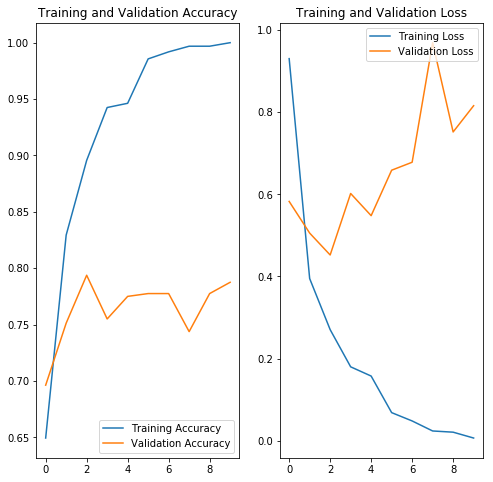

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As can be seen, the final values of accuracy and loss function are very close (in a simple analysis, we can say there is no over-fit). On other hand, if we look the evolution of these scores, there are differences among the test and validation curves, this can indicate that our model is over-fitted. A good way to avoid over-fit is to use the dropout.

### Making predictions

We are going to make prediction over 32 images splitted into two classes.

In [15]:
# Setting the prediction set

pred_set = keras.preprocessing.image_dataset_from_directory(
  'Dataset/Test',
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size)

pred_set = pred_set.prefetch(buffer_size=AUTOTUNE) # To a better performance

Found 32 files belonging to 2 classes.


In [16]:
loss, accuracy = cnn_model.evaluate(pred_set)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 855ms/step - loss: 0.0341 - accuracy: 1.0000
Test accuracy : 1.0


Predictions:
 [0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1]
Labels:
 [[[[2.5125000e+01 3.0125000e+01 3.6125000e+01]
   [3.0875000e+01 3.5875000e+01 4.1875000e+01]
   [4.3250000e+01 4.8250000e+01 5.4250000e+01]
   ...
   [1.2837500e+02 1.2337500e+02 1.2037500e+02]
   [1.2512500e+02 1.2712500e+02 1.2412500e+02]
   [1.2850000e+02 1.2950000e+02 1.2450000e+02]]

  [[2.0625000e+01 2.3625000e+01 3.0625000e+01]
   [3.1750000e+01 3.4750000e+01 4.1750000e+01]
   [3.9375000e+01 4.2375000e+01 4.9375000e+01]
   ...
   [1.2750000e+02 1.2250000e+02 1.1850000e+02]
   [1.3425000e+02 1.3025000e+02 1.2725000e+02]
   [1.3100000e+02 1.2700000e+02 1.2400000e+02]]

  [[2.5375000e+01 2.8375000e+01 3.5375000e+01]
   [2.6375000e+01 3.3375000e+01 3.9375000e+01]
   [2.7875000e+01 3.2875000e+01 3.6875000e+01]
   ...
   [1.2687500e+02 1.2187500e+02 1.1587500e+02]
   [1.3287500e+02 1.2787500e+02 1.2387500e+02]
   [1.2900000e+02 1.2400000e+02 1.1800000e+02]]

  ...

  [[2.0000000e+00 6.6000000e+01

Confusion Matrix 

[[7 9]
 [9 7]]




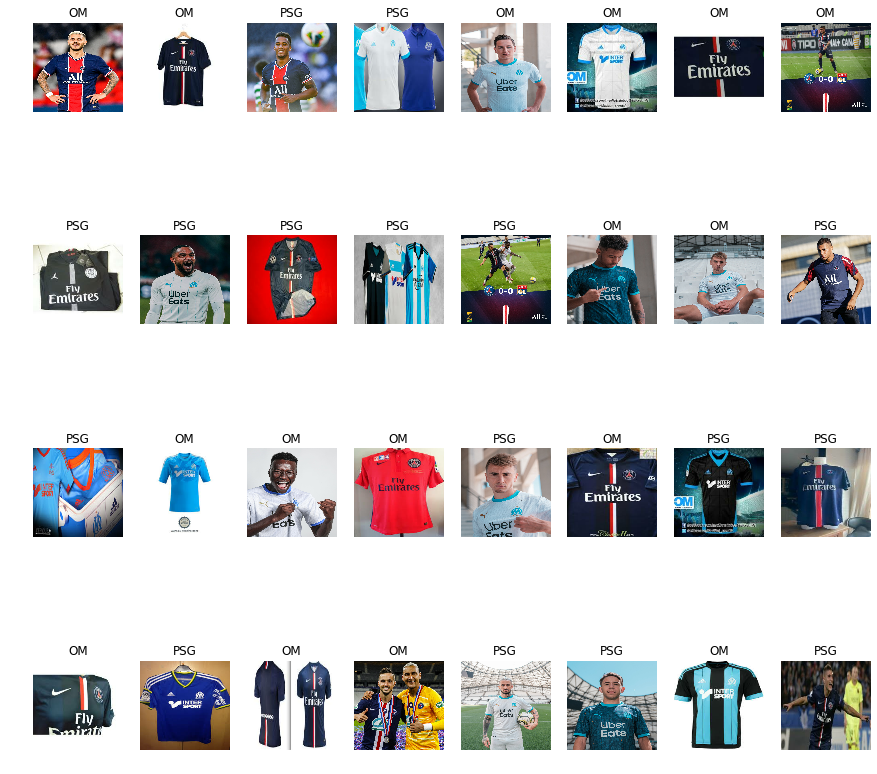

In [17]:
#Retrieve a batch of images from the test set
image_batch, label_batch = pred_set.as_numpy_iterator().next()

# Apply a sigmoid since our model returns logits
predictions = cnn_model.predict(pred_set).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', image_batch)
print('\n')

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(label_batch, predictions.numpy())
print('Confusion Matrix \n')
print(cm)
print('\n')

plt.figure(figsize=(15, 15))
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

## Model with Dropout

As recommended by TensorFlow API, dropout can reduce over-fit. Beyond the dropout, is also recommended to use the data augmentation, but this technique is more appropriate to a small dataset. For this problem, the data augmentation does not show a significant gain.

**Dropout** from TensorFlow 

The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

### Creating the model

In [18]:
cnn_model_dr = Sequential([
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # Applying the dropout
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(units=1, activation='sigmoid')
])


### Compiling the model

In [19]:
cnn_model_dr.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [20]:
cnn_model_dr.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 64)       

### Training the model

In [21]:
epochs = 15
history_dr = cnn_model_dr.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

Epoch 1/15
50/50 [==============================] - 45s 876ms/step - loss: 0.8353 - accuracy: 0.6014 - val_loss: 0.5599 - val_accuracy: 0.7225
Epoch 2/15
50/50 [==============================] - 41s 819ms/step - loss: 0.3925 - accuracy: 0.8316 - val_loss: 0.4770 - val_accuracy: 0.7713
Epoch 3/15
50/50 [==============================] - 42s 846ms/step - loss: 0.3532 - accuracy: 0.8434 - val_loss: 0.6273 - val_accuracy: 0.6900
Epoch 4/15
50/50 [==============================] - 42s 839ms/step - loss: 0.2776 - accuracy: 0.8933 - val_loss: 0.4422 - val_accuracy: 0.7987
Epoch 5/15
50/50 [==============================] - 41s 822ms/step - loss: 0.1945 - accuracy: 0.9237 - val_loss: 0.4733 - val_accuracy: 0.7987
Epoch 6/15
50/50 [==============================] - 41s 821ms/step - loss: 0.1644 - accuracy: 0.9371 - val_loss: 0.5187 - val_accuracy: 0.8087
Epoch 7/15
50/50 [==============================] - 41s 828ms/step - loss: 0.1170 - accuracy: 0.9542 - val_loss: 0.4825 - val_accuracy: 0.8075

### Learning curves (Accuracy and loss function)

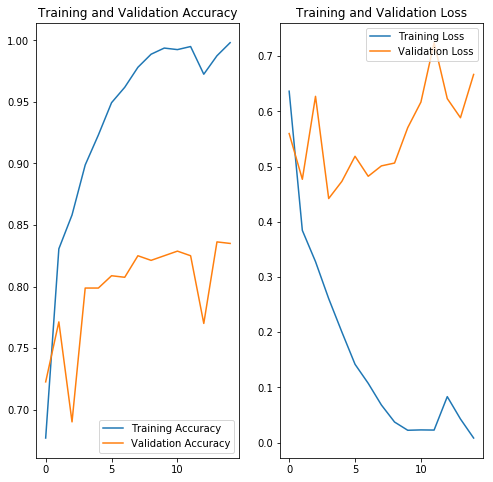

In [22]:
acc_dr = history_dr.history['accuracy']
val_acc_dr = history_dr.history['val_accuracy']

loss_dr = history_dr.history['loss']
val_loss_dr = history_dr.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_dr, label='Training Accuracy')
plt.plot(epochs_range, val_acc_dr, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_dr, label='Training Loss')
plt.plot(epochs_range, val_loss_dr, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model with dropout shows curves similar to the model without dropout. So, as the final values of accuracy and loss are close, we can suppose that our model is not over-fitted.

### Making predictions

In [23]:
loss, accuracy = cnn_model_dr.evaluate(pred_set)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 968ms/step - loss: 0.0704 - accuracy: 0.9688
Test accuracy : 0.96875


Predictions:
 [1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 1 0 0]
Labels:
 [0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1]


Confusion Matrix 

[[8 8]
 [9 7]]




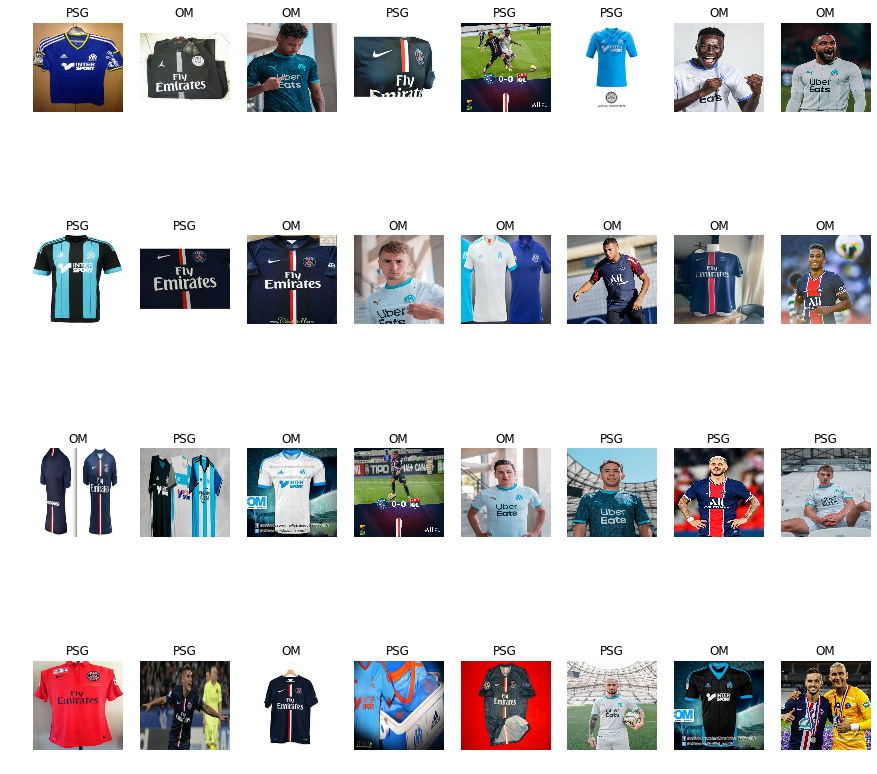

In [24]:
#Retrieve a batch of images from the test set
image_batch, label_batch = pred_set.as_numpy_iterator().next()

# Apply a sigmoid since our model returns logits
predictions = cnn_model_dr.predict(pred_set).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
print('\n')

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(label_batch, predictions.numpy())
print('Confusion Matrix \n')
print(cm)
print('\n')

plt.figure(figsize=(15, 15))
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

## Model with Image Augmentation and Dropout

### Data Augmentation

**From TensorFlow**

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

**Note**

We try this technique, but remember we have a larger dataset. Maybe the image augmentation does not show a significant gain.

In [25]:
# Data augmentation with keras sequential
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

### Creating the model

In [26]:
cnn_model_f = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
 # layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.2),
  #layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(units=1, activation='sigmoid')
])

### Compiling the model

In [27]:
cnn_model_f.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [28]:
cnn_model_f.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 45, 45, 32)       

### Training the model

In [29]:
epochs = 15
history_f = cnn_model_f.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs
)

Epoch 1/15
50/50 [==============================] - 39s 752ms/step - loss: 1.2938 - accuracy: 0.5933 - val_loss: 0.6769 - val_accuracy: 0.6450
Epoch 2/15
50/50 [==============================] - 38s 772ms/step - loss: 0.4330 - accuracy: 0.7966 - val_loss: 0.6324 - val_accuracy: 0.6850
Epoch 3/15
50/50 [==============================] - 37s 741ms/step - loss: 0.3737 - accuracy: 0.8434 - val_loss: 0.9082 - val_accuracy: 0.6350
Epoch 4/15
50/50 [==============================] - 39s 784ms/step - loss: 0.3414 - accuracy: 0.8632 - val_loss: 0.9257 - val_accuracy: 0.6525
Epoch 5/15
50/50 [==============================] - 39s 779ms/step - loss: 0.3465 - accuracy: 0.8503 - val_loss: 0.6081 - val_accuracy: 0.7387
Epoch 6/15
50/50 [==============================] - 37s 741ms/step - loss: 0.3310 - accuracy: 0.8607 - val_loss: 0.5004 - val_accuracy: 0.7850
Epoch 7/15
50/50 [==============================] - 37s 749ms/step - loss: 0.2802 - accuracy: 0.8922 - val_loss: 0.6372 - val_accuracy: 0.7700

### Learning curves (Accuracy and loss function)

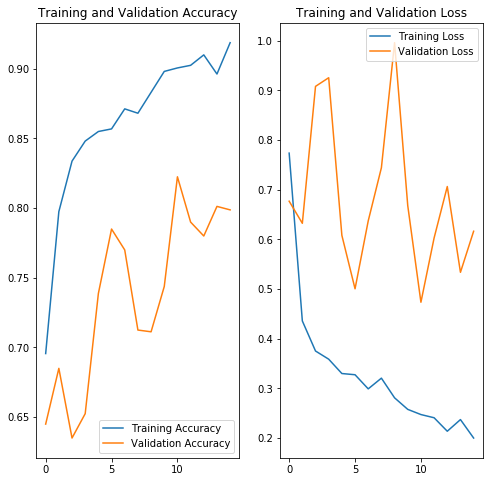

In [30]:
acc_f = history_f.history['accuracy']
val_acc_f = history_f.history['val_accuracy']

loss_f = history_f.history['loss']
val_loss_f = history_f.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_f, label='Training Accuracy')
plt.plot(epochs_range, val_acc_f, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_f, label='Training Loss')
plt.plot(epochs_range, val_loss_f, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Making predictions

In [31]:
loss, accuracy = cnn_model_f.evaluate(pred_set)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 1s/step - loss: 0.0976 - accuracy: 0.9688
Test accuracy : 0.96875


Predictions:
 [0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 0 1 1]
Labels:
 [1 0 1 0 1 0 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0]


Confusion Matrix 

[[7 9]
 [8 8]]




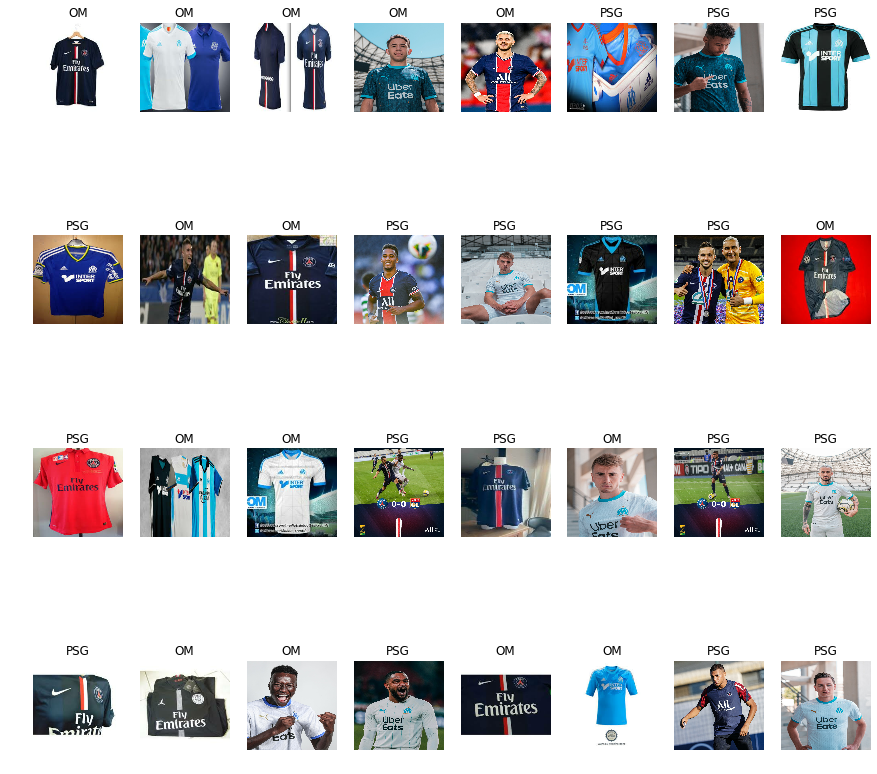

In [32]:
#Retrieve a batch of images from the test set
image_batch, label_batch = pred_set.as_numpy_iterator().next()

# Apply a sigmoid since our model returns logits
predictions = cnn_model_f.predict(pred_set).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
print('\n')

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(label_batch, predictions.numpy())
print('Confusion Matrix \n')
print(cm)
print('\n')

plt.figure(figsize=(15, 15))
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

## Remarks about the models made by hand

# Build the CNN with pre-trained model

As said in the **[TensorFlow](https://www.tensorflow.org/tutorials/images/transfer_learning)** website:

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

## Setting the images, training and test set

Following the instructions by TensorFlow we set the images, training and test set as

In [33]:
IMG_SHAPE = (160, 160) # Size of image

In [34]:
train_set_t = keras.preprocessing.image_dataset_from_directory(
  'Dataset/Training',
  shuffle=True,
  image_size=IMG_SHAPE,
  batch_size=batch_size) # Training set

Found 1600 files belonging to 2 classes.


In [35]:
test_set_t = keras.preprocessing.image_dataset_from_directory(
  'Dataset/Validation',
  shuffle=True,
  image_size=IMG_SHAPE,
  batch_size=batch_size) # Test set

Found 800 files belonging to 2 classes.


**Configure the dataset for performance** for this dataset we do not apply it.

**Data Augmentation** is recommended by TensorFlow, but here we do not consider it, due to have a satisfactory dataset. In the example found in TensorFlow website, they consider a dataset with 2000 images, here we have 8000. After some test, the data augmentation is not necessary to us, in this example.

## Downloading the base model from the **MobileNet V2**

**From TensorFlow**

The MobileNet V2 is a model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

### Downloading

In [36]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input # To download

### Rescaling the images

**From TensorFlow**

In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel vaues in $[-1,1]$, but at this point, the pixel values in your images are in $[0-255]$.

In [37]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## Creating the base model

**From TensorFlow**

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [38]:
IMG_SHAPE = IMG_SHAPE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet') # Create the base model from the pre-trained model MobileNet V2

We need to convert the image size $(160x160x3)$ into $(5x5x1280)$. Here, an example to one batch of images.

In [39]:
image_batch, label_batch = next(iter(train_set_t))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction

**From TensorFlow**

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

*Freeze the convolutional base*

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [40]:
base_model.trainable = False

### Summaty model from the base model

In [41]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

## Building the model

### Add a classification head

**From TensorFlow**

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [42]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [43]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### The model

In [44]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compiling the model

In [45]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Summary model - final model

In [46]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1281  

In [47]:
len(model.trainable_variables)

2

## Training the model

In [55]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(test_set_t)

25/25 [==============================] - 31s 971ms/step - loss: 0.5638 - accuracy: 0.6787


In [56]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.56
initial accuracy: 0.68


In [57]:
history = model.fit(train_set_t,
                    epochs=initial_epochs,
                    validation_data=test_set_t)

Epoch 1/15
50/50 [==============================] - 83s 2s/step - loss: 0.5238 - accuracy: 0.7206 - val_loss: 0.5489 - val_accuracy: 0.6825
Epoch 2/15
50/50 [==============================] - 83s 2s/step - loss: 0.5139 - accuracy: 0.7275 - val_loss: 0.5349 - val_accuracy: 0.6988
Epoch 3/15
50/50 [==============================] - 83s 2s/step - loss: 0.4909 - accuracy: 0.7569 - val_loss: 0.5229 - val_accuracy: 0.7163
Epoch 4/15
50/50 [==============================] - 82s 2s/step - loss: 0.4688 - accuracy: 0.7594 - val_loss: 0.5115 - val_accuracy: 0.7175
Epoch 5/15
50/50 [==============================] - 82s 2s/step - loss: 0.4644 - accuracy: 0.7719 - val_loss: 0.5022 - val_accuracy: 0.7125
Epoch 6/15
50/50 [==============================] - 82s 2s/step - loss: 0.4534 - accuracy: 0.7663 - val_loss: 0.4930 - val_accuracy: 0.7300
Epoch 7/15
50/50 [==============================] - 83s 2s/step - loss: 0.4383 - accuracy: 0.7887 - val_loss: 0.4843 - val_accuracy: 0.7362
Epoch 8/15
50/50 [==

## Learning curves (Accuracy and loss function)

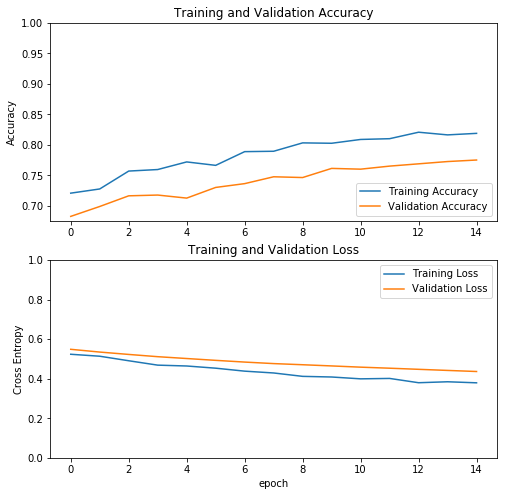

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

For this example we do not need to the Fine Tuning, the model is generalized.

## Making predictions

### Setting the prediction set

In [59]:
pred_set_t = keras.preprocessing.image_dataset_from_directory(
  'Dataset/Test',
  shuffle=True,
  image_size=(160, 160),
  batch_size=batch_size)

pred_set_t = pred_set_t.prefetch(buffer_size=AUTOTUNE) # To a better performance

Found 32 files belonging to 2 classes.


In [60]:
loss, accuracy = model.evaluate(pred_set_t)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 502ms/step - loss: 0.2298 - accuracy: 0.9375
Test accuracy : 0.9375


Predictions:
 [0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1]
Labels:
 [0 1 0 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1]


Confusion Matrix 

[[16  0]
 [ 2 14]]




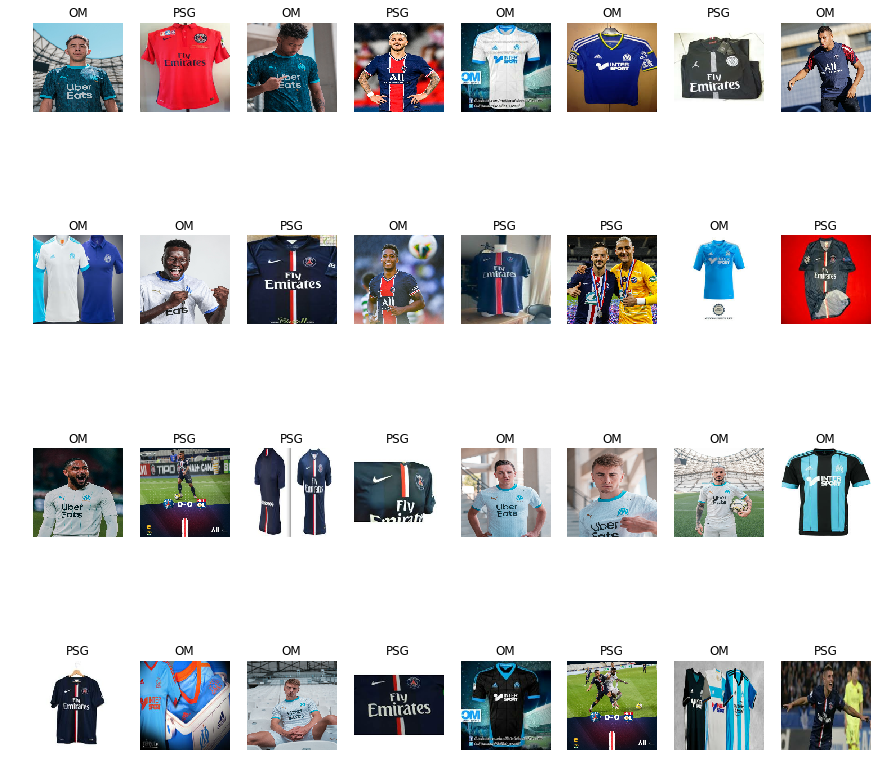

In [61]:
#Retrieve a batch of images from the test set
image_batch, label_batch = pred_set_t.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
print('\n')

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(label_batch, predictions.numpy())
print('Confusion Matrix \n')
print(cm)
print('\n')

plt.figure(figsize=(15, 15))
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

# Conclusion

